# Thermoelasticity-based modal damage identification

## Import packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pysfmov as sfmov
#import km
import FLife
from tqdm import tqdm

## Input parameters

### Thermal video

In [16]:
#k = 6.51 # slope endurance curve
#bas = -1/k
#B = 800.26
#C = B**k  # s = B * N**bas or s^k * N = C

In [17]:
filename = './data/rec0.sfmov'
fs = 400
dt = 1 / fs

data = sfmov.get_data(filename)
km = 1.2 * 10**(-8) * 10**(-6) # stress amplitude in MPa
stress = data * km * 10

location = 72, 40, 3, 3 #vert mode area
interval = [54, 56] # HZ
f_step = 0.1

In [22]:
stress

array([[[22310.842, 22299.451, 22293.754, ..., 22208.174, 22219.598,
         22242.438],
        [22316.54 , 22299.451, 22265.254, ..., 22191.027, 22231.018,
         22202.459],
        [22316.54 , 22310.842, 22299.451, ..., 22236.727, 22208.174,
         22202.459],
        ...,
        [22644.969, 22656.23 , 22622.43 , ..., 22492.518, 22475.531,
         22520.805],
        [22656.23 , 22673.117, 22689.996, ..., 22469.865, 22498.18 ,
         22509.494],
        [22689.996, 22695.617, 22673.117, ..., 22492.518, 22464.203,
         22503.838]],

       [[22310.842, 22270.957, 22310.842, ..., 22208.174, 22202.459,
         22213.887],
        [22322.229, 22316.54 , 22305.146, ..., 22236.727, 22231.018,
         22219.598],
        [22282.36 , 22305.146, 22299.451, ..., 22225.309, 22208.174,
         22185.309],
        ...,
        [22661.863, 22695.617, 22639.336, ..., 22481.193, 22537.77 ,
         22464.203],
        [22656.23 , 22673.117, 22650.602, ..., 22509.494, 22475.531,
   

### Material

In [18]:
k = 6.51 # slope endurance curve
B = 800.26 # endurance curve 
C = B**k

In [19]:
tdata = ThermalData(stress, dt)

In [20]:
m = tdata.get_life(C, k, 'Modal', interval = interval, location = location)
tb = tdata.get_life(C, k, 'TovoBenasciutti', location = location)
d = tdata.get_life(C, k, 'Dirlik', location = location)
r = tdata.get_life(C, k, 'Rainflow', location = location)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 71.29it/s]


In [21]:
print(f'          Rainflow: {r:4.0f} s')
print(f'            Dirlik: {d:4.0f} s')
print(f'  Tovo-Benasciutti: {tb:4.0f} s')
print(f'             Modal: {m:4.0f} s')

          Rainflow: 2197 s
            Dirlik: 1242 s
  Tovo-Benasciutti: 1376 s
             Modal: 6206414069935038 s


In [ ]:
m = tdata.get_life(C, k, 'Modal', interval = interval)#, location = location)

In [ ]:
tb = tdata.get_life(C, k, 'TovoBenasciutti')

In [ ]:
(x,y,w,h) = location 

In [ ]:
ref = m[y:(y+h), x:(x+w)]

In [ ]:
ref

In [ ]:
np.mean(ref, axis = (0,1))

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(tb)
plt.colorbar()
#plt.clim(0.9*1e10,1e19)

## Computation

In [14]:
class ThermalData():
        
    def __init__(self, x, dt):
        
        self.x = x
        self.dt = dt
    
    def get_life(self, C, k, method = None, interval = None, location = None, f_step = 0.1):
        
        if method not in ['Modal', 'TovoBenasciutti', 'Dirlik', 'Rainflow']:
            raise ValueError('Method must be one of: Modal, TovoBenasciutti, Dirlik, Rainflow')
        
        N = self.x.shape[0]
        dt = 1 / fs
        ds = self.x - self.x[0,:,:]
        
        life = np.zeros(shape=(ds.shape[1], ds.shape[2]))
        
        if location is not None:
            (x,y,w,h) = location    
            ds = ds[:, y:(y+h), x:(x+w)]
            
        npixels = ds.shape[1] * ds.shape[2]  
        
        if method == 'Modal':
            
            if interval == None:
                raise ValueError('Frequency interval must be defined')
                
            with tqdm(total = npixels) as pbar:   
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):    
                        fft  = np.abs(np.fft.rfft(ds[:,i,j], N) * 2 / N)
                        freq = np.fft.rfftfreq(N, 1/fs)
            
                        y_peak = np.max(fft[(freq > interval[0]) & (freq < interval[1])])
                        x_peak = freq[np.where(fft == y_peak)[0][0]]
            
                        amplitude = np.mean(fft[(freq >= x_peak - f_step) & (freq <= x_peak + f_step)], axis = 0)
                
                        damage =  x_peak / (C / amplitude**k) 
                
                        life[i,j] = 1 / damage
                
                        pbar.update(1)
        
        elif method == 'TovoBenasciutti':
            
            with tqdm(total = npixels) as pbar:
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        tb = FLife.TovoBenasciutti(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = tb.get_life(C = C, k = k, method = "method 2")
                        pbar.update(1)
                    
        elif method == 'Dirlik':
            
            with tqdm(total = npixels) as pbar:
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        dirlik = FLife.Dirlik(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = dirlik.get_life(C = C, k = k)
                        pbar.update(1)
                    
        elif method == 'Rainflow':
            
            with tqdm(total = npixels) as pbar:    
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        rf = FLife.Rainflow(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = rf.get_life(C = C, k = k)
                        pbar.update(1)

        if location is not None:
            return np.mean(life, axis = (0,1))
        else:
            return life

In [8]:
x  =stress                
    
N = x.shape[0]
dt = 1 / fs
ds = x - x[0,:,:]

life = np.zeros(shape=(ds.shape[1], ds.shape[2]))
for i in range(ds.shape[1]):
    for j in range(ds.shape[2]):    
        fft  = np.abs(np.fft.rfft(ds[:,i,j], N) * 2 / N)
        freq = np.fft.rfftfreq(N, 1/fs)

        y_peak = np.max(fft[(freq > interval[0]) & (freq < interval[1])])
        x_peak = freq[np.where(fft == y_peak)[0][0]]

        amplitude = np.mean(fft[(freq >= x_peak - f_step) & (freq <= x_peak + f_step)], axis = 0)

        damage =  x_peak / (C / amplitude**k) 

        life[i,j] = 1 / damage

In [9]:
x_peak

55.006875859482435

In [10]:
amplitude

0.522892186383577

In [11]:
life

array([[1.01968217e+18, 6.34742534e+17, 5.89491376e+17, ...,
        2.16841087e+17, 1.43430285e+17, 1.35288430e+17],
       [1.73059143e+18, 1.09254947e+18, 8.77305884e+16, ...,
        4.87106019e+17, 9.31606951e+17, 2.96551430e+17],
       [3.78595056e+17, 1.40423833e+17, 8.88235818e+18, ...,
        3.86977007e+17, 9.93793488e+17, 3.72946893e+17],
       ...,
       [7.32583571e+18, 3.92640559e+18, 4.21666830e+18, ...,
        2.19867774e+19, 6.03523501e+18, 2.47506982e+18],
       [2.16336208e+19, 2.53774305e+18, 2.87591063e+18, ...,
        9.09642318e+18, 1.48604478e+20, 1.73780354e+19],
       [3.16415101e+18, 7.41453819e+18, 3.13442767e+18, ...,
        1.71060722e+18, 7.86507317e+17, 9.83454868e+18]])

<IPython.core.display.Javascript object>


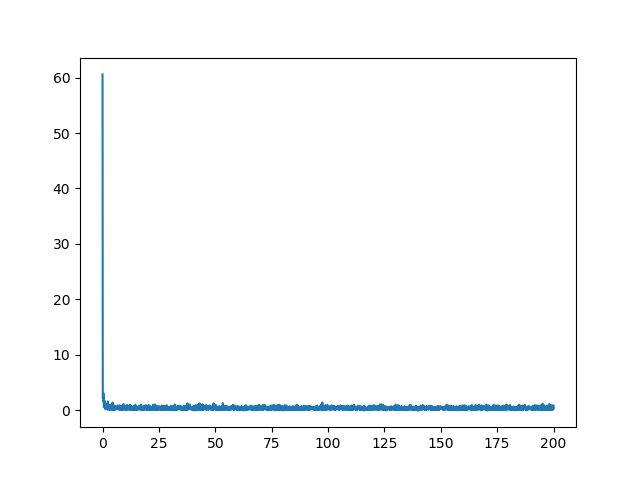

In [13]:
%matplotlib notebook
plt.plot(freq,np.abs(fft))